In [1]:
import string
import numpy as np
import pandas as pd
from data import get_train_test_split
from models.utils import damerau_levenshtein_distance, regexp_processing
from tqdm import tqdm
from collections import Counter
from itertools import product

import seaborn as sns

In [2]:
def create_ngram(n=2):
    combs = product(string.ascii_lowercase, repeat=n)
    ngrams = []
    for el in combs:
        ngrams.append("".join(el))
    
    return ngrams

In [3]:
class NaiveBayes:
    def __init__(self, n_gram, classes):
        """
        Args:
            n (int)
        """
        self.ngrams = create_ngram(n_gram)
        self.probs = pd.DataFrame(1, index=np.arange(len(self.ngrams)).tolist(), columns=classes)
        self.classes = classes
        self.y_prob = {}
        for label in classes: self.y_prob[label] = 0
    
    def fit(self, dataset):
        total_grams_per_class = {}
        for label in self.classes: total_grams_per_class[label] = 0
        
        for idx in tqdm(range(len(dataset))):
            text = dataset.iloc[idx]["destination"]
            target = dataset.iloc[idx]["code"]
            
            self.y_prob[target] += 1
            total_grams_per_class[target] += 1
            
            for idx in range(len(self.ngrams)):
                if self.ngrams[idx] in text.lower(): self.probs.loc[idx, target] += 1
        
        # divide by the total number of word for each column
        for target in self.classes:
            self.probs[target] /= total_grams_per_class[target] * len(self.ngrams)
            self.y_prob[target] /= sum(self.y_prob.values())
    
    def predict(self, text):
        pred_targets = {}
        for label in self.classes: pred_targets[label] = 1
        
        for idx in range(len(self.ngrams)):
            if self.ngrams[idx] in text.lower():
                for label in self.classes:
                    pred_targets[label] *= self.y_prob[label] * self.probs.loc[idx, label]
        
        return pred_targets
    
    def evaluate(self, dataset):
        accuracy = 0
        errors = []

        for idx in tqdm(range(len(dataset))):
            text = dataset.iloc[idx]["destination"]
            target = dataset.iloc[idx]["code"]

            preds = model(text)
            label = max(preds, key=preds.get)

            if label == target: accuracy += 1
            else: errors.append((text, target, label))


        accuracy = accuracy / len(dataset)
        print(f"Accuracy: {accuracy} | Errors: {len(errors)}")

        return accuracy, errors
    
    def __call__(self, text): return self.predict(text)

In [4]:
train_df, test_df = get_train_test_split("10_ports.csv", transform=regexp_processing)

{'SEED': 42}


In [6]:
classes = ['FRBES','ESSDR','NLRTM','BEANR','FRLEH',
           'FRSML','ESBIO','FRMTX','FRIRK','FRBOD']

In [8]:
ngrams_grid = np.arange(1,5)
accuracies = []

for n in ngrams_grid:
    model = NaiveBayes(n, classes)
    model.fit(train_df)
    
    accuracy, _ = model.evaluate(test_df)
    accuracies.append(accuracy)

 40%|████      | 80/198 [00:00<00:00, 796.25it/s]

Accuracy: 0.14 | Errors: 43


 37%|███▋      | 74/198 [00:00<00:00, 361.29it/s]

Accuracy: 0.48 | Errors: 26


  0%|          | 0/198 [00:00<?, ?it/s]

Accuracy: 0.5 | Errors: 25


100%|██████████| 50/50 [00:02<00:00, 19.24it/s]

Accuracy: 0.38 | Errors: 31


/home/achraf/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Accuracy'), Text(0.5, 0, 'N-gram'), Text(0, 0.5, 'Accuracy')]

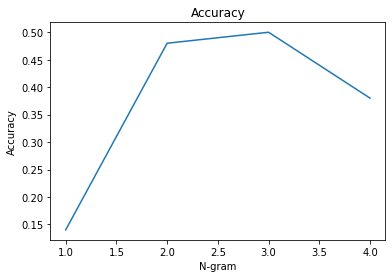

In [9]:
sns.lineplot(ngrams_grid, accuracies).set(title="Accuracy", xlabel="N-gram", ylabel="Accuracy")